<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/dog_denoiser_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Image Denoiser with Auto Encoder



## Import

In [1]:
from sys import path
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, preprocessing
from skimage.util import random_noise
from tqdm import tqdm
import numpy as np
import keras

## Dataset

In [26]:
# DATASET- Dogs pictures, 1000 for trainset, 500 for testset

# Change the dataset filepath
base_dir = path[0] + "/drive/MyDrive/dog-cat-dataset/"
train_dir = base_dir + "/train/"
validation_dir = base_dir + "/validation/"
test_dir = base_dir + "/test/"

batch_size = 32

# We use data augmentation on train set to prevent overfitting
train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Final train and test data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(148, 148), 
    batch_size=batch_size, 
    classes=["dogs"], 
    color_mode="grayscale"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(148, 148), 
    batch_size=batch_size, 
    classes=["dogs"], 
    color_mode="grayscale"
)

Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


In [27]:
def add_noise(image):
  """Add noise to a given img"""
  #image=random_noise(image, mode='gaussian', mean=0, var=0.01)
  image=random_noise(image, mode='s&p', amount=0.2, salt_vs_pepper=0.5)
  #image=random_noise(image, mode='poisson') 
  #image=random_noise(image, mode='speckle',  mean=0, var=0.1)

  return image



# Train dataset, we will generate ~10k images thanks to image augmentation
true_train_images = []
noised_train_images = []

i = 0
for image_batch, y in tqdm(train_generator):
  for image in image_batch:
    noised_train_images.append(add_noise(image))
    true_train_images.append(image)

  if (i > 10000 // batch_size): # stop iteration after 10K imgs
    break
  i +=1


# Test dataset, 500 not augmented images
true_test_images = []
noised_test_images = []

i = 0
for image_batch, y in tqdm(test_generator):
  for image in image_batch:
    noised_test_images.append(add_noise(image))
    true_test_images.append(image)

  if (i > 500 // batch_size):  # the whole test set
    break
  i +=1

313it [01:09,  4.51it/s]
100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


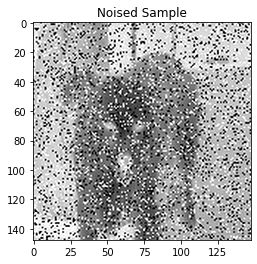

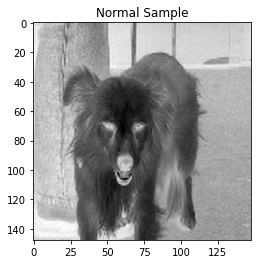

In [24]:
# Convert to Numpy array
noised_train_images = np.array(noised_train_images)
noised_test_images = np.array(noised_test_images)
true_train_images = np.array(true_train_images)
true_test_images = np.array(true_test_images)


# Show a sample
noised_sample = noised_test_images[0]
true_sample = true_test_images[0]

plt.imshow(noised_sample.reshape(148, 148), cmap='binary', interpolation='lanczos')
plt.title("Noised Sample")
plt.show()

plt.imshow(true_sample.reshape(148, 148), cmap='binary', interpolation='lanczos')
plt.title("Normal Sample")
plt.show()

## Model

In [7]:
# ENCODER

inputs      = keras.layers.Input(shape=(148, 148, 1))

e_conv1     = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
pool1       = keras.layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = keras.layers.BatchNormalization()(pool1)
e_conv2     = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2       = keras.layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = keras.layers.BatchNormalization()(pool2)
e_conv3     = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h           = keras.layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

In [8]:
# DECODER

d_conv1   = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1       = keras.layers.UpSampling2D((2, 2))(d_conv1)
d_conv2   = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2       = keras.layers.UpSampling2D((2, 2))(d_conv2)
d_conv3   = keras.layers.Conv2D(16, (3, 3), activation='relu')(up2)
up3       = keras.layers.UpSampling2D((2, 2))(d_conv3)

outputs   = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

In [9]:
# AUTO ENCODER

ae = keras.Model(inputs, outputs)

ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 148, 148, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0     

## Training

In [10]:
epochs = 100

ae.compile(optimizer='adam', loss='mse')

history = ae.fit(noised_train_images, 
                 true_train_images, 
                 epochs=epochs, 
                 validation_data=(noised_test_images, true_test_images))

Epoch 1/100
308/308 [==============================] - 23s 40ms/step - loss: 0.0086 - val_loss: 0.0494
Epoch 2/100
308/308 [==============================] - 12s 38ms/step - loss: 0.0057 - val_loss: 0.0102
Epoch 3/100
308/308 [==============================] - 12s 38ms/step - loss: 0.0051 - val_loss: 0.0070
Epoch 4/100
308/308 [==============================] - 11s 37ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 5/100
308/308 [==============================] - 12s 37ms/step - loss: 0.0046 - val_loss: 0.0082
Epoch 6/100
308/308 [==============================] - 11s 37ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 7/100
308/308 [==============================] - 11s 37ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 8/100
308/308 [==============================] - 11s 37ms/step - loss: 0.0040 - val_loss: 0.0061
Epoch 9/100
308/308 [==============================] - 12s 37ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 10/100
308/308 [==============================] - 11s 37ms/step - l

## Results

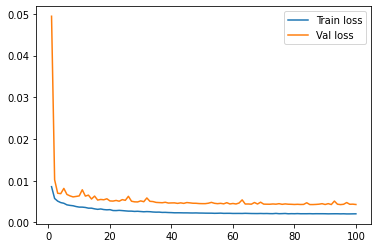

In [11]:
# LOG RESULTS

epochs_range = range(1, epochs + 1)
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(epochs_range, loss, label="Train loss")
plt.plot(epochs_range, val_loss, label="Val loss")

plt.legend()
plt.show()

## Prediction

In [20]:
preds = ae.predict(noised_test_images[0:1])

1/1 [==============================] - 0s 39ms/step


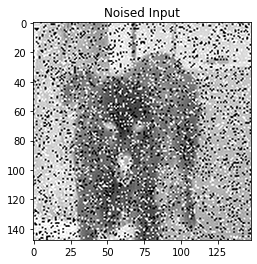

In [21]:
# The input with noise

plt.title("Noised Input")
plt.imshow(noised_test_images[0].reshape(148, 148), cmap='binary', interpolation='lanczos')

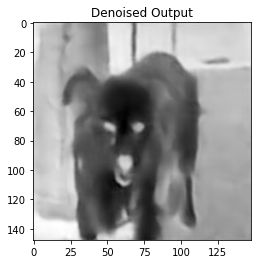

In [22]:
# The results of prediction

plt.title("Denoised Output")
plt.imshow(preds[0].reshape(148, 148), cmap='binary', interpolation='lanczos')

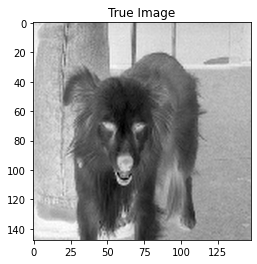

In [23]:
# The real image

plt.title("True Image")
plt.imshow(true_test_images[0].reshape(148, 148), cmap='binary', interpolation='lanczos')